## LSTM Based Model

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import h5py
import time
from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import pickle
import re
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from torchvision.models import densenet121
from rouge_score import rouge_scorer
from sklearn.metrics import precision_score, recall_score, f1_score
from nltk.translate.bleu_score import sentence_bleu
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os


## Feature Extraction using ChexNet Pretrained Weights

In [2]:
# Step 1: Load Pretrained DenseNet-121 from PyTorch
densenet = models.densenet121(weights=None)
state_dict = densenet.state_dict()

# Step 2: Load the Keras Weights from .h5 File
keras_weights_path = 'brucechou1983_CheXNet_Keras_0.3.0_weights.h5'
with h5py.File(keras_weights_path, 'r') as f:
    keras_weights = {k: np.array(v) for k, v in f.items()}

# Step 3: Map Keras Weights to PyTorch Model
def load_weights(state_dict, keras_weights):
    for key in keras_weights.keys():
        if 'kernel' in key or 'bias' in key:  # Identify weight types
            pytorch_key = key.replace('kernel', 'weight').replace('bias', 'bias')
            pytorch_key = pytorch_key.replace('/', '.')  # Adjust naming format
            
            if pytorch_key in state_dict:
                weight = torch.tensor(keras_weights[key])
                if len(weight.shape) == 4:  # For Conv weights
                    weight = weight.permute(3, 2, 0, 1)
                state_dict[pytorch_key] = weight
    return state_dict

# Apply Weights to PyTorch DenseNet
state_dict = load_weights(state_dict, keras_weights)
densenet.load_state_dict(state_dict)

print("Weights loaded successfully into PyTorch DenseNet-121 model.")

# Step 4: Use DenseNet-121 as a Feature Extractor
class CheXNetFeatureExtractor(nn.Module):
    def __init__(self, densenet):
        super(CheXNetFeatureExtractor, self).__init__()
        self.features = densenet.features
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Global Average Pooling
    
    def forward(self, x):
        x = self.features(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        return x

# Instantiate Feature Extractor
chexnet = CheXNetFeatureExtractor(densenet)

# Example Input Tensor
input_tensor = torch.randn(1, 3, 224, 224)
output = chexnet(input_tensor)
print("Feature Vector Shape:", output.shape)  # Should be [1, 1024]


Weights loaded successfully into PyTorch DenseNet-121 model.
Feature Vector Shape: torch.Size([1, 1024])


In [3]:
# Load Dataset
train_dataset = pd.read_csv('Train_Data.csv')
test_dataset = pd.read_csv('Test_Data.csv')
cv_dataset = pd.read_csv('CV_Data.csv')

# Tokenize and Clean Text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    return text

# Build Vocabulary
def build_vocab(texts, min_freq=1):
    counter = Counter()
    for text in texts:
        counter.update(clean_text(text).split())

    vocab = {"<PAD>": 0, "<START>": 1, "<END>": 2, "<UNK>": 3}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

# Create Vocabulary
vocab = build_vocab(train_dataset['Report'].values)
vocab_size = len(vocab)
print("Vocabulary Size:", vocab_size)

# Text to Sequence
def text_to_sequence(text, vocab):
    tokens = clean_text(text).split()
    return [vocab.get("<START>")] + [vocab.get(token, vocab["<UNK>"]) for token in tokens] + [vocab.get("<END>")]


Vocabulary Size: 1429


In [4]:
train_dataset.shape, test_dataset.shape, cv_dataset.shape

((2758, 4), (399, 4), (550, 4))

In [5]:
cv_dataset.head()

,Person_id,Image1,Image2,Report
0,CXR3690_IM-1841_0,CXR3690_IM-1841-1001.png,CXR3690_IM-1841-2001.png,startseq the heart again enlarged . aorta tor...
1,CXR3691_IM-1842_0,CXR3691_IM-1842-1001.png,CXR3691_IM-1842-3003.png,startseq the heart normal size . the mediasti...
2,CXR3692_IM-1843_0,CXR3692_IM-1843-1001.png,CXR3692_IM-1843-2001.png,startseq stable cardiomediastinal silhouette ....
3,CXR3693_IM-1844_0,CXR3693_IM-1844-1001.png,CXR3693_IM-1844-1002.png,startseq the lungs are clear bilaterally . sp...
4,CXR3694_IM-1845_0,CXR3694_IM-1845-1001.png,CXR3694_IM-1845-2001.png,startseq interval removal leftsided chest tube...


In [6]:
pad_size = 153   # Max length

In [5]:
X_train, X_test, X_cv = train_dataset['Person_id'], test_dataset['Person_id'], cv_dataset['Person_id'][:546]
y_train, y_test, y_cv = train_dataset['Report'], test_dataset['Report'], cv_dataset['Report'][:546]

## Custom Tokenizer 

In [7]:
import re
from collections import Counter

class CustomTokenizer:
    def __init__(self, min_freq=1, special_tokens=["<PAD>", "<START>", "<END>", "<UNK>"]):
        """
        A custom tokenizer for converting text to token sequences and vice versa.
        
        Args:
            min_freq (int): Minimum frequency for a word to be included in the vocabulary.
            special_tokens (list): List of special tokens like <PAD>, <START>, etc.
        """
        self.word_index = {}  # Word to index mapping
        self.index_word = {}  # Index to word mapping
        self.min_freq = min_freq
        self.special_tokens = special_tokens
        self.word_counter = Counter()

        # Initialize special tokens
        for idx, token in enumerate(self.special_tokens):
            self.word_index[token] = idx
            self.index_word[idx] = token

    def fit_on_texts(self, texts):
        """
        Fit the tokenizer on a list of text data to build the vocabulary.
        
        Args:
            texts (list of str): List of text sequences.
        """
        # Count word frequencies
        for text in texts:
            tokens = self._clean_and_tokenize(text)
            self.word_counter.update(tokens)
        
        # Add words to the vocabulary if they meet the min_freq criteria
        for word, freq in self.word_counter.items():
            if freq >= self.min_freq and word not in self.word_index:
                idx = len(self.word_index)
                self.word_index[word] = idx
                self.index_word[idx] = word

    def texts_to_sequences(self, texts):
        """
        Convert a list of texts to sequences of word indices.
        
        Args:
            texts (list of str): List of text sequences.
        
        Returns:
            list of list of int: List of token index sequences.
        """
        sequences = []
        for text in texts:
            tokens = self._clean_and_tokenize(text)
            sequence = [self.word_index.get(token, self.word_index["<UNK>"]) for token in tokens]
            sequences.append(sequence)
        return sequences

    def sequences_to_texts(self, sequences):
        """
        Convert a list of sequences of word indices back to text.
        
        Args:
            sequences (list of list of int): List of token index sequences.
        
        Returns:
            list of str: List of text sequences.
        """
        texts = []
        for seq in sequences:
            text = " ".join([self.index_word.get(idx, "<UNK>") for idx in seq if idx != self.word_index["<PAD>"]])
            texts.append(text)
        return texts

    def _clean_and_tokenize(self, text):
        """
        Clean and tokenize text into a list of words.
        
        Args:
            text (str): Input text string.
        
        Returns:
            list of str: List of tokens.
        """
        text = text.lower()
        text = re.sub(r"[^a-z0-9\s]", "", text)  # Remove special characters
        return text.split()

    def __call__(self, text):
        """
        Makes the tokenizer callable for a single text input.
        
        Args:
            text (str): A single text sequence.
        
        Returns:
            list of int: Token index sequence.
        """
        tokens = self._clean_and_tokenize(text)
        return [self.word_index.get(token, self.word_index["<UNK>"]) for token in tokens]

In [8]:
# Initialize and Fit Tokenizer
tokenizer = CustomTokenizer()
tokenizer.fit_on_texts(y_train.values)

In [9]:
vocab_size = len(tokenizer.word_index.keys()) + 1
vocab_size

1430

## Generate Embeddings using  GloVe Vectors

In [15]:
# Path to GloVe file
glove_path = 'glove.6B.300d.txt'

# Load GloVe Vectors into a Dictionary
def load_glove_vectors(glove_path):
    glove_dict = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            glove_dict[word] = vector
    return glove_dict

# Load GloVe
glove_vectors = load_glove_vectors(glove_path)
print(f"Loaded {len(glove_vectors)} words from GloVe.")

Loaded 400000 words from GloVe.


In [16]:
embedding_matrix = np.zeros((vocab_size,300))
for word, i in tokenizer.word_index.items():
    if word in glove_vectors.keys():
        vec = glove_vectors[word]
        embedding_matrix[i] = vec
    else:
        continue

## Model

In [45]:
class MultiModalModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, embedding_matrix, hidden_dim, image_input_dim, output_dim, dropout_rate=0.5):
        super(MultiModalModel, self).__init__()
        
        # Text Input Branch
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False  # Make embeddings non-trainable
        
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=False)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, bidirectional=False)
        
        # Image Input Branch
        self.image_fc = nn.Linear(image_input_dim, hidden_dim)  # Updated to match image_input_dim
        
        # Fusion Branch
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout1 = nn.Dropout(0.8)
        self.dropout2 = nn.Dropout(0.6)
        
        # Output Layer
        self.output = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, text_input, image_input):
        # Text Processing Path
        embedded = self.embedding(text_input)  # [B, seq_len, embedding_dim]
        lstm_out1, _ = self.lstm1(embedded)    # [B, seq_len, hidden_dim]
        lstm_out2, _ = self.lstm2(lstm_out1)  # [B, seq_len, hidden_dim]
        
        # Image Processing Path
        image_input = image_input.view(image_input.size(0), -1)  # Flatten image: [B, D]
        image_features = torch.relu(self.image_fc(image_input))  # Linear layer: [B, hidden_dim]
        image_features = image_features.unsqueeze(1).repeat(1, lstm_out2.size(1), 1)
        
        # Combine Features
        combined_features = image_features + lstm_out2  # [B, seq_len, hidden_dim]
        
        # Output Predictions
        outputs = self.output(combined_features)  # [B, seq_len, vocab_size]
        return outputs


In [40]:


# Model Parameters
#vocab_size = vocab_size          # Vocabulary Size
embedding_dim = 300        # GloVe Embedding Dimension
hidden_dim = 256           # Hidden Dimension for LSTMs
image_input_dim = 1024     # Image Feature Dimension
output_dim = vocab_size          # Output Classes (Vocabulary Size)

dropout_rate = 0.5

# Instantiate Model
model = MultiModalModel(vocab_size, embedding_dim, embedding_matrix, hidden_dim, image_input_dim, output_dim, dropout_rate)

# Summary
text_input_sample = torch.randint(0, vocab_size, (4, 153))  # Batch of 4, sequence length 153
image_input_sample = torch.randn(4, image_input_dim)        # Batch of 4, image feature dimension 2048

output = model(text_input_sample, image_input_sample)
print("Output Shape:", output.shape)  # Should be [4, 1427]

Output Shape: torch.Size([4, 153, 1430])


## Custom DataSet For X-Rays

In [19]:
def load_image(id_, report):
    '''Loads the Image Features with their corresponding Ids'''
    img_feature = chexnet[id_.decode('utf-8')][0]
    return img_feature, report

In [20]:
# Image preprocessing transforms for CheXNet feature extraction
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
class CheXNetReportDataset(Dataset):
    def __init__(self, csv_file, root_dir, chexnet, tokenizer, transform=None, max_length=153):
        """
        Args:
            csv_file (str): Path to the CSV file containing Person_id and Report.
            root_dir (str): Root directory containing the image files.
            chexnet (CheXNetFeatureExtractor): Pretrained CheXNet feature extractor.
            tokenizer (CustomTokenizer): Tokenizer for converting text to sequences.
            transform: Image preprocessing transforms.
            max_length (int): Maximum length of tokenized reports (padded/truncated).
        """
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.chexnet = chexnet
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def pad_sequence(self, sequence):
        """Pad or truncate a tokenized sequence to the maximum length."""
        if len(sequence) < self.max_length:
            sequence += [0] * (self.max_length - len(sequence))  # Pad with 0 (e.g., <PAD>)
        else:
            sequence = sequence[:self.max_length]
        return sequence

    def load_image(self, image_path):
        """Load and preprocess an image."""
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        return image

    def __getitem__(self, idx):
        person_id = self.data.iloc[idx]["Person_id"]
        report = self.data.iloc[idx]["Report"]
        
        # Append root directory to the image path
        image_path = os.path.join(self.root_dir, self.data.iloc[idx]["Image1"])
        image = self.load_image(image_path)
        

        # Extract features using CheXNet
        with torch.no_grad():
            img_feature = self.chexnet(image.unsqueeze(0)).squeeze(0)  # Pass through the feature extractor

        # Tokenize and pad the corresponding report
        tokenized_report = self.tokenizer(report)
        padded_report = self.pad_sequence(tokenized_report)

        return img_feature, torch.tensor(padded_report, dtype=torch.long)


In [25]:
BATCH_SIZE=8
EPOCHS = 20

In [26]:
# DataLoader Function
def create_dataloader(dataset, batch_size, shuffle=True):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2,pin_memory=True)

In [27]:
root_dir = "NLMCXR/images"
# Assuming chexnet is a preloaded dictionary and tokenizer is initialized
dataset_train = CheXNetReportDataset("Train_Data.csv",root_dir,chexnet=chexnet,tokenizer=tokenizer,transform=image_transform)
dataset_test = CheXNetReportDataset("Test_Data.csv",root_dir,chexnet=chexnet,tokenizer=tokenizer,transform=image_transform)
dataset_valid = CheXNetReportDataset("CV_Data.csv",root_dir,chexnet=chexnet,tokenizer=tokenizer,transform=image_transform)

data_loader_train = create_dataloader(dataset_train, BATCH_SIZE)
data_loader_test = create_dataloader(dataset_test, BATCH_SIZE)
data_loader_valid = create_dataloader(dataset_valid, BATCH_SIZE)



In [28]:
# Print number of samples in each dataset
print(f"Number of samples in the training dataset: {len(dataset_train)}")
print(f"Number of samples in the validation dataset: {len(dataset_valid)}")
print(f"Number of samples in the test dataset: {len(dataset_test)}")

# Print number of batches in each DataLoader
print(f"Number of batches in the training DataLoader: {len(data_loader_train)}")
print(f"Number of batches in the validation DataLoader: {len(data_loader_valid)}")
print(f"Number of batches in the test DataLoader: {len(data_loader_test)}")


Number of samples in the training dataset: 2758
Number of samples in the validation dataset: 550
Number of samples in the test dataset: 399
Number of batches in the training DataLoader: 345
Number of batches in the validation DataLoader: 69
Number of batches in the test DataLoader: 50


In [29]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.word_index["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [30]:
def calculate_accuracy(predicted, target, pad_idx):
    mask = target != pad_idx  # Exclude <PAD> tokens
    correct = (predicted[mask] == target[mask]).sum().item()
    total = mask.sum().item()
    return correct / total if total > 0 else 0.0


## Training Loop

In [27]:
from tqdm import tqdm

# Training Loop with TQDM
def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, device, epochs, save_path='best_model.pth'):
    epoch_train_loss = []
    epoch_val_loss = []
    epoch_train_acc = []
    epoch_val_acc = []
    best_val_loss = float('inf')

    model.to(device)
    for epoch in range(epochs):
        print(f'EPOCH : {epoch + 1}')
        start = time.time()
        
        # Training Phase
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0
        with tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}") as train_bar:
            for img_features, reports in train_bar:
                img_features, reports = img_features.to(device), reports.to(device)
                optimizer.zero_grad()
                
                # Forward pass
                outputs = model(reports, img_features)
                outputs = outputs.view(-1, outputs.size(-1))
                reports = reports.view(-1)
                
                # Compute loss
                loss = criterion(outputs, reports)
                
                # Backward pass with gradient clipping
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
                optimizer.step()
                
                train_loss += loss.item()
                
                # Update accuracy
                _, predicted = torch.max(outputs, dim=1)
                correct_train += (predicted == reports).sum().item()
                total_train += reports.size(0)
                
                # Update tqdm bar
                train_bar.set_postfix(loss=loss.item(), acc=correct_train / total_train)


        train_loss /= len(train_dataloader)
        train_acc = correct_train / total_train
        epoch_train_loss.append(train_loss)
        epoch_train_acc.append(train_acc)

        # Validation Phase
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            with tqdm(val_dataloader, desc=f"Validation Epoch {epoch + 1}") as val_bar:
                for img_features, reports in val_bar:
                    img_features, reports = img_features.to(device), reports.to(device)
                    
                    # Forward pass for validation
                    outputs = model(reports, img_features)
                    outputs = outputs.view(-1, outputs.size(-1))  # [B * seq_len, vocab_size]
                    reports = reports.view(-1)  # [B * seq_len]

                    # Compute validation loss
                    loss = criterion(outputs, reports)
                    val_loss += loss.item()
                    
                    # Compute accuracy
                    _, predicted = torch.max(outputs, dim=1)
                    correct_val += (predicted == reports).sum().item()
                    total_val += reports.size(0)
                    
                    # Update tqdm bar with loss and accuracy
                    val_bar.set_postfix(loss=loss.item(), acc=correct_val / total_val)

        val_loss /= len(val_dataloader)
        val_acc = correct_val / total_val
        epoch_val_loss.append(val_loss)
        epoch_val_acc.append(val_acc)

        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved with validation loss: {val_loss:.4f}")

        print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
        print(f"Time Taken for this Epoch: {time.time() - start:.2f} sec")

    return epoch_train_loss, epoch_val_loss, epoch_train_acc, epoch_val_acc


In [25]:
from datetime import datetime
# Get the current timestamp
current_timestamp = datetime.now()
# Format the timestamp without spaces or dashes (e.g., YYYYMMDD_HHMMSS)
formatted_timestamp = current_timestamp.strftime("%Y%m%d_%H%M%S")
formatted_timestamp


'20241218_211642'

In [26]:
model_name = f'encoder_decoder_epoch_final_{formatted_timestamp}.pth'

In [30]:


# Train the Model
epoch_train_loss, epoch_val_loss, epoch_train_acc, epoch_val_acc = train_model(model, data_loader_train, data_loader_valid, optimizer, criterion, device, EPOCHS)

# Save Model Weights
torch.save(model.state_dict(), model_name)

EPOCH : 1


Validation Epoch 1: 100%|██████████| 69/69 [00:33<00:00,  2.06it/s, acc=0.803, loss=0.79] 


Best model saved with validation loss: 1.0796
Training Loss: 2.0841, Training Accuracy: 0.7750
Validation Loss: 1.0796, Validation Accuracy: 0.8030
Time Taken for this Epoch: 210.56 sec
EPOCH : 2


Validation Epoch 2: 100%|██████████| 69/69 [00:34<00:00,  2.02it/s, acc=0.823, loss=1.16] 


Best model saved with validation loss: 0.9897
Training Loss: 0.9880, Training Accuracy: 0.8189
Validation Loss: 0.9897, Validation Accuracy: 0.8230
Time Taken for this Epoch: 200.26 sec
EPOCH : 3


Validation Epoch 3: 100%|██████████| 69/69 [00:32<00:00,  2.10it/s, acc=0.855, loss=0.969]


Best model saved with validation loss: 0.8864
Training Loss: 0.9031, Training Accuracy: 0.8455
Validation Loss: 0.8864, Validation Accuracy: 0.8550
Time Taken for this Epoch: 198.77 sec
EPOCH : 4


Validation Epoch 4: 100%|██████████| 69/69 [00:33<00:00,  2.05it/s, acc=0.876, loss=0.758]


Best model saved with validation loss: 0.7340
Training Loss: 0.7757, Training Accuracy: 0.8691
Validation Loss: 0.7340, Validation Accuracy: 0.8759
Time Taken for this Epoch: 198.78 sec
EPOCH : 5


Validation Epoch 5: 100%|██████████| 69/69 [00:33<00:00,  2.04it/s, acc=0.91, loss=0.92]  


Best model saved with validation loss: 0.5955
Training Loss: 0.6289, Training Accuracy: 0.8994
Validation Loss: 0.5955, Validation Accuracy: 0.9095
Time Taken for this Epoch: 199.20 sec
EPOCH : 6


Validation Epoch 6: 100%|██████████| 69/69 [00:32<00:00,  2.12it/s, acc=0.928, loss=0.458]


Best model saved with validation loss: 0.4869
Training Loss: 0.5083, Training Accuracy: 0.9240
Validation Loss: 0.4869, Validation Accuracy: 0.9280
Time Taken for this Epoch: 198.90 sec
EPOCH : 7


Validation Epoch 7: 100%|██████████| 69/69 [00:42<00:00,  1.64it/s, acc=0.939, loss=0.269]


Best model saved with validation loss: 0.4032
Training Loss: 0.4162, Training Accuracy: 0.9371
Validation Loss: 0.4032, Validation Accuracy: 0.9388
Time Taken for this Epoch: 240.14 sec
EPOCH : 8


Validation Epoch 8: 100%|██████████| 69/69 [00:41<00:00,  1.65it/s, acc=0.949, loss=0.346]


Best model saved with validation loss: 0.3369
Training Loss: 0.3419, Training Accuracy: 0.9474
Validation Loss: 0.3369, Validation Accuracy: 0.9485
Time Taken for this Epoch: 249.40 sec
EPOCH : 9


Validation Epoch 9: 100%|██████████| 69/69 [00:42<00:00,  1.64it/s, acc=0.956, loss=0.184] 


Best model saved with validation loss: 0.2889
Training Loss: 0.2858, Training Accuracy: 0.9560
Validation Loss: 0.2889, Validation Accuracy: 0.9562
Time Taken for this Epoch: 250.25 sec
EPOCH : 10


Validation Epoch 10: 100%|██████████| 69/69 [00:40<00:00,  1.68it/s, acc=0.962, loss=0.239] 


Best model saved with validation loss: 0.2535
Training Loss: 0.2454, Training Accuracy: 0.9629
Validation Loss: 0.2535, Validation Accuracy: 0.9619
Time Taken for this Epoch: 251.78 sec
EPOCH : 11


Validation Epoch 11: 100%|██████████| 69/69 [00:40<00:00,  1.69it/s, acc=0.967, loss=0.521] 


Best model saved with validation loss: 0.2260
Training Loss: 0.2136, Training Accuracy: 0.9678
Validation Loss: 0.2260, Validation Accuracy: 0.9666
Time Taken for this Epoch: 249.36 sec
EPOCH : 12


Validation Epoch 12: 100%|██████████| 69/69 [00:33<00:00,  2.07it/s, acc=0.971, loss=0.173] 


Best model saved with validation loss: 0.2011
Training Loss: 0.1874, Training Accuracy: 0.9722
Validation Loss: 0.2011, Validation Accuracy: 0.9705
Time Taken for this Epoch: 241.09 sec
EPOCH : 13


Validation Epoch 13: 100%|██████████| 69/69 [00:33<00:00,  2.07it/s, acc=0.974, loss=0.275] 


Best model saved with validation loss: 0.1801
Training Loss: 0.1653, Training Accuracy: 0.9757
Validation Loss: 0.1801, Validation Accuracy: 0.9742
Time Taken for this Epoch: 193.28 sec
EPOCH : 14


Validation Epoch 14: 100%|██████████| 69/69 [00:33<00:00,  2.08it/s, acc=0.976, loss=0.182] 


Best model saved with validation loss: 0.1628
Training Loss: 0.1467, Training Accuracy: 0.9787
Validation Loss: 0.1628, Validation Accuracy: 0.9765
Time Taken for this Epoch: 195.51 sec
EPOCH : 15


Validation Epoch 15: 100%|██████████| 69/69 [00:33<00:00,  2.08it/s, acc=0.979, loss=0.194] 


Best model saved with validation loss: 0.1480
Training Loss: 0.1308, Training Accuracy: 0.9808
Validation Loss: 0.1480, Validation Accuracy: 0.9788
Time Taken for this Epoch: 194.17 sec
EPOCH : 16


Validation Epoch 16: 100%|██████████| 69/69 [00:32<00:00,  2.10it/s, acc=0.981, loss=0.198] 


Best model saved with validation loss: 0.1351
Training Loss: 0.1172, Training Accuracy: 0.9825
Validation Loss: 0.1351, Validation Accuracy: 0.9807
Time Taken for this Epoch: 195.18 sec
EPOCH : 17


Validation Epoch 17: 100%|██████████| 69/69 [00:32<00:00,  2.10it/s, acc=0.982, loss=0.0651]


Best model saved with validation loss: 0.1238
Training Loss: 0.1055, Training Accuracy: 0.9841
Validation Loss: 0.1238, Validation Accuracy: 0.9824
Time Taken for this Epoch: 195.13 sec
EPOCH : 18


Validation Epoch 18: 100%|██████████| 69/69 [00:33<00:00,  2.09it/s, acc=0.984, loss=0.0847]


Best model saved with validation loss: 0.1140
Training Loss: 0.0953, Training Accuracy: 0.9855
Validation Loss: 0.1140, Validation Accuracy: 0.9837
Time Taken for this Epoch: 196.02 sec
EPOCH : 19


Validation Epoch 19: 100%|██████████| 69/69 [00:33<00:00,  2.09it/s, acc=0.985, loss=0.0832]


Best model saved with validation loss: 0.1060
Training Loss: 0.0863, Training Accuracy: 0.9868
Validation Loss: 0.1060, Validation Accuracy: 0.9853
Time Taken for this Epoch: 196.30 sec
EPOCH : 20


Validation Epoch 20: 100%|██████████| 69/69 [00:32<00:00,  2.10it/s, acc=0.986, loss=0.199] 

Best model saved with validation loss: 0.0998
Training Loss: 0.0784, Training Accuracy: 0.9882
Validation Loss: 0.0998, Validation Accuracy: 0.9860
Time Taken for this Epoch: 194.71 sec


## Plot Train and Validation Losses

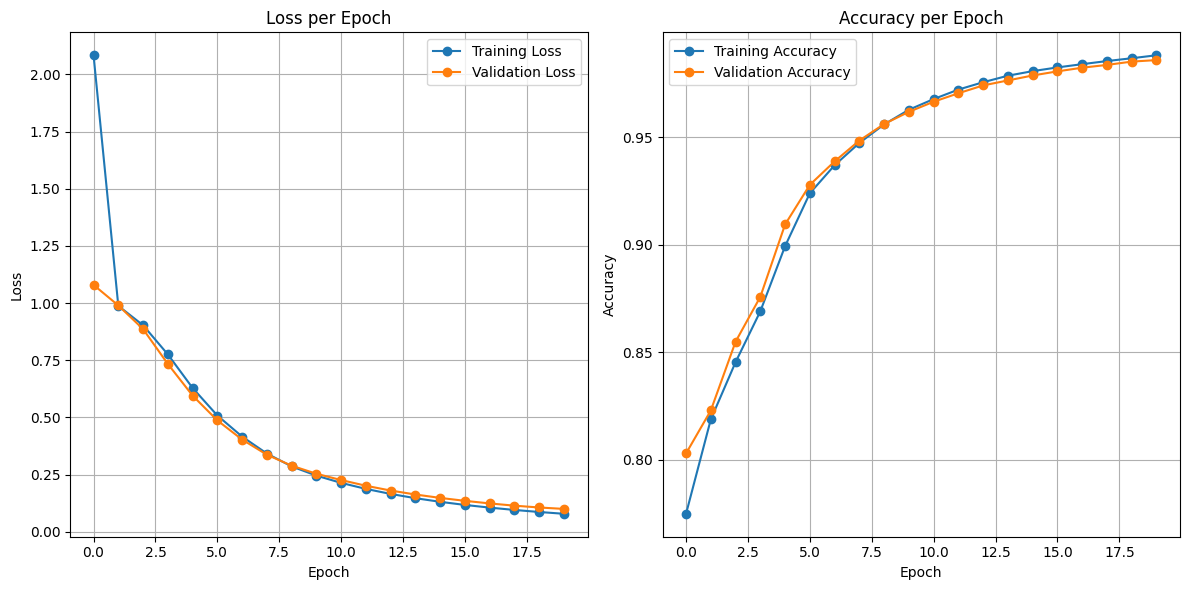

In [31]:
import matplotlib.pyplot as plt

# Plotting Loss and Accuracy
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Loss Plot
axes[0].plot(epoch_train_loss, label='Training Loss', marker='o')
axes[0].plot(epoch_val_loss, label='Validation Loss', marker='o')
axes[0].set_title('Loss per Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy Plot
axes[1].plot(epoch_train_acc, label='Training Accuracy', marker='o')
axes[1].plot(epoch_val_acc, label='Validation Accuracy', marker='o')
axes[1].set_title('Accuracy per Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [27]:
# Load the best model
model_name ='encoder_decoder_epoch_final1.pth'
model.load_state_dict(torch.load(model_name))
model.to(device)

/tmp/ipykernel_1737725/2990672773.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_name))


MultiModalModel(
  (embedding): Embedding(1430, 300)
  (lstm1): LSTM(300, 256, batch_first=True)
  (lstm2): LSTM(256, 256, batch_first=True)
  (image_fc): Linear(in_features=1024, out_features=256, bias=True)
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (dropout1): Dropout(p=0.8, inplace=False)
  (dropout2): Dropout(p=0.6, inplace=False)
  (output): Linear(in_features=256, out_features=1430, bias=True)
)

## Model Predictions

In [28]:
import torch
from tqdm import tqdm

def predict(model, dataloader, tokenizer, device):
    """
    Generates predictions for the input data using the trained model.
    
    Args:
        model: Trained PyTorch model.
        dataloader: DataLoader for the test or validation dataset.
        tokenizer: PyTorch-compatible tokenizer to map indices back to words.
        device: Device to run the model on (e.g., "cuda" or "cpu").
    
    Returns:
        predictions: List of predicted sentences (decoded).
        targets: List of ground truth sentences (decoded).
    """
    model.eval()
    predictions = []
    targets = []
    
    with torch.no_grad():
        for img_features, reports in tqdm(dataloader, desc="Generating Predictions"):
            # Move data to the device
            img_features, reports = img_features.to(device), reports.to(device)
            
            # Forward pass
            outputs = model(reports, img_features)  # [B, seq_len, vocab_size]
            
            # Get predicted token indices
            predicted_indices = torch.argmax(outputs, dim=2)  # [B, seq_len]
            
            # Decode predictions and ground truth
            for i in range(predicted_indices.size(0)):  # Iterate over batch
                # Decode predicted tokens
                pred_tokens = tokenizer.sequences_to_texts([predicted_indices[i].tolist()])[0]
                
                # Decode ground truth tokens
                target_tokens = tokenizer.sequences_to_texts([reports[i].tolist()])[0]
                
                # Log missing tokens
                missing_tokens = [token for token in target_tokens.split() if token not in tokenizer.word_index]
                if missing_tokens:
                    print(f"Missing tokens in tokenizer vocabulary: {missing_tokens}")

                predictions.append(pred_tokens)
                targets.append(target_tokens)
    
    return predictions, targets


#############


# Predict on validation dataset
valid_predictions, ground_truth = predict(model, data_loader_valid, tokenizer, device)

# Display some predictions and ground truth
for i in range(5):
    print(f"Prediction {i + 1}: {valid_predictions[i]}")
    print(f"Ground Truth {i + 1}: {ground_truth[i]}")
    print("-" * 50)


Generating Predictions: 100%|██████████| 69/69 [00:47<00:00,  1.44it/s]

Prediction 1: startseq lungs are clear bilaterally with no focal infiltrate pleural effusion pneumothoraces cardiomediastinal silhouette within normal limits and soft tissues are unremarkable endseq
Ground Truth 1: startseq lungs are clear bilaterally with no focal infiltrate pleural effusion pneumothoraces cardiomediastinal silhouette within normal limits and soft tissues are unremarkable endseq
--------------------------------------------------
Prediction 2: startseq the heart and lungs have the interval both lungs are clear and epanded heart and mediastinum normal endseq
Ground Truth 2: startseq the heart and lungs have the interval both lungs are clear and epanded heart and mediastinum normal endseq
--------------------------------------------------
Prediction 3: startseq the cardiomediastinal silhouette normal size and contour calcified left hilar lymph granulomas no focal consolidation pneumothora large pleural effusion old fracture right mid clavicle endseq
Ground Truth 3: start

## Evaluate Metrics

In [31]:
def evaluate_test_accuracy(model, test_dataloader, tokenizer, device):
    """
    Computes the test accuracy of the model on the given test dataset.

    Args:
        model: Trained PyTorch model.
        test_dataloader: DataLoader for the test dataset.
        tokenizer: Tokenizer used in the dataset.
        device: Device to run the model on (e.g., "cuda" or "cpu").

    Returns:
        accuracy: The overall test accuracy as a float.
    """
    model.eval()
    correct = 0
    total = 0
    pad_idx = tokenizer.word_index["<PAD>"]

    with torch.no_grad():
        for img_features, reports in tqdm(test_dataloader, desc="Evaluating Test Accuracy"):
            img_features, reports = img_features.to(device), reports.to(device)
            
            # Forward pass
            outputs = model(reports, img_features)  # [B, seq_len, vocab_size]
            predicted_indices = torch.argmax(outputs, dim=2)  # [B, seq_len]
            
            # Flatten predicted and true values
            predicted_indices = predicted_indices.view(-1)  # [B * seq_len]
            reports = reports.view(-1)  # [B * seq_len]

            # Mask <PAD> tokens
            mask = reports != pad_idx  # Exclude <PAD> tokens from accuracy
            correct += (predicted_indices[mask] == reports[mask]).sum().item()
            total += mask.sum().item()

    accuracy = correct / total if total > 0 else 0.0
    return accuracy


In [32]:
# Compute test accuracy
test_accuracy = evaluate_test_accuracy(model, data_loader_test, tokenizer, device)
print(f"Test Accuracy: {test_accuracy:.4f}")

Evaluating Test Accuracy: 100%|██████████| 50/50 [00:31<00:00,  1.57it/s]

Test Accuracy: 0.9689


### Evaluate Metrics

In [37]:

def compute_bleu(predictions, targets):
    """
    Calculates the average BLEU score for all predictions.
    
    Args:
        predictions: List of predicted sentences.
        targets: List of ground truth sentences.
    
    Returns:
        avg_bleu: Average BLEU score across all predictions.
    """
    scores = []
    for pred, target in zip(predictions, targets):
        target_tokens = target.split()
        pred_tokens = pred.split()
        score = sentence_bleu([target_tokens], pred_tokens)
        scores.append(score)
    avg_bleu = sum(scores) / len(scores)
    return avg_bleu

def compute_rouge(predictions, references):
    """
    Computes ROUGE scores for the given predictions and references.

    Args:
        predictions (list): List of predicted reports (strings).
        references (list): List of ground truth reports (strings).

    Returns:
        rouge_scores (dict): Dictionary with average ROUGE-1, ROUGE-2, and ROUGE-L scores.
    """
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

    for pred, ref in tqdm(zip(predictions, references), total=len(predictions), desc="Computing ROUGE"):
        score = scorer.score(ref, pred)
        for key in scores.keys():
            scores[key].append(score[key].fmeasure)  # Use F1-score as the metric
    
    # Average the scores across all examples
    avg_scores = {key: sum(value) / len(value) for key, value in scores.items()}
    return avg_scores


In [38]:
# Generate predictions and ground truth reports
test_predictions, ground_truth = predict(model, data_loader_test, tokenizer, device)

Generating Predictions: 100%|██████████| 50/50 [00:33<00:00,  1.51it/s]


In [39]:
# Display some predictions and ground truth
for i in range(5):
    print(f"Prediction {i + 1}: {test_predictions[i]}")
    print(f"Ground Truth {i + 1}: {ground_truth[i]}")
    print("-" * 50)


Prediction 1: startseq apparent scarring within the cardiomediastinal lungs are otherwise clear no pleural effusions pneumothoraces heart and mediastinum normal size and contour endseq
Ground Truth 1: startseq apparent scarring within the lingula lungs are otherwise clear no pleural effusions pneumothoraces heart and mediastinum normal size and contour endseq
--------------------------------------------------
Prediction 2: startseq cardiac and mediastinal contours are within normal limits prior granulomatous disease the lungs are otherwise clear bony structures are intact endseq
Ground Truth 2: startseq cardiac and mediastinal contours are within normal limits prior granulomatous disease the lungs are otherwise clear bony structures are intact endseq
--------------------------------------------------
Prediction 3: startseq heart size within normal limits there are surgical clips the left mediastinum there no pneumothora there small left pleural effusion abnormal endseq within the media

In [34]:
# Compute ROUGE scores
rouge_scores = compute_rouge(test_predictions, ground_truth)
print("ROUGE Scores:")
print(f"ROUGE-1: {rouge_scores['rouge1']:.4f}")
print(f"ROUGE-2: {rouge_scores['rouge2']:.4f}")
print(f"ROUGE-L: {rouge_scores['rougeL']:.4f}")

# Compute BLEU score
bleu_score = compute_bleu(test_predictions, ground_truth)
print(f"BLEU Score: {bleu_score:.4f}")

Computing ROUGE:   0%|          | 0/399 [00:00<?, ?it/s]

Computing ROUGE: 100%|██████████| 399/399 [00:00<00:00, 510.71it/s]


ROUGE Scores:
ROUGE-1: 0.9789
ROUGE-2: 0.9576
ROUGE-L: 0.9786
BLEU Score: 0.9461


In [35]:
def compute_f1_precision_recall(predictions, references, tokenizer):
    """
    Computes F1-Score, Precision, and Recall for the predictions against the references.

    Args:
        predictions (list): List of predicted sentences (strings).
        references (list): List of ground truth sentences (strings).
        tokenizer: Tokenizer used in the dataset for word-index mapping.

    Returns:
        metrics (dict): Dictionary containing F1-Score, Precision, and Recall.
    """
    # Flatten token-level predictions and references
    pred_tokens = []
    ref_tokens = []
    pad_idx = tokenizer.word_index["<PAD>"]

    for pred, ref in zip(predictions, references):
        pred_indices = [tokenizer.word_index.get(word, pad_idx) for word in pred.split()]
        ref_indices = [tokenizer.word_index.get(word, pad_idx) for word in ref.split()]
        
        # Ensure both sequences have the same length
        min_length = min(len(pred_indices), len(ref_indices))
        pred_tokens.extend(pred_indices[:min_length])
        ref_tokens.extend(ref_indices[:min_length])
    
    # Compute Precision, Recall, and F1-Score
    precision = precision_score(ref_tokens, pred_tokens, average="weighted",zero_division=0)
    recall = recall_score(ref_tokens, pred_tokens, average="weighted",zero_division=0)
    f1 = f1_score(ref_tokens, pred_tokens, average="weighted",zero_division=0)

    return {"Precision": precision, "Recall": recall, "F1-Score": f1}


In [36]:
# Compute F1, Precision, and Recall
metrics = compute_f1_precision_recall(test_predictions, ground_truth, tokenizer)
print(f"Precision: {metrics['Precision']:.4f}")
print(f"Recall: {metrics['Recall']:.4f}")
print(f"F1-Score: {metrics['F1-Score']:.4f}")


Precision: 0.9419
Recall: 0.9510
F1-Score: 0.9453
